# Project: Social Media Addiction Severity Prediction (Supervised Regression)

**Confidentiality Disclaimer**
This project showcases advanced regression techniques applied to a simulated dataset regarding student well-being, demonstrating skills relevant to predictive modeling, rigorous validation, and advanced feature engineering in behavioral science contexts.
All data shown here are open-source and not affiliated with the client organization.

---

**Business Understanding (CRISP-DM)**
**Goal:** The objective is to apply supervised learning (Regression) to predict the numerical severity of social media addiction ($	ext{Addicted\_Score}$) based on an extended set of habits and demographic factors. The analysis utilizes **5-Fold Cross-Validation** to ensure model stability and rigorously identifies the factors most strongly correlated with higher addiction scores.

**Dataset Source:** Students Social Media Addiction Survey Data (Simulated/Open-Source)

---
**Author:** David Barahona  
**Date:** Dec 12, 2025  
*In this project, I applied machine learning techniques similar to those used in a confidential WIL project with an industry partner. This open dataset was used to demonstrate equivalent analytical and technical skills.*

## 1. Initial Data Assessment and Feature Engineering

The initial step involves data loading and the crucial process of **feature engineering** to derive more meaningful predictors from the existing variables, which can significantly improve model performance and interpretability. We are creating two new interaction features to capture underlying complexity.

### 1.1. Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

### 1.2. Load Data and Create New Features

Two features are engineered to capture complex relationships:
1.  **Usage/Sleep Ratio:** $\frac{\text{Avg\_Daily\_Usage\_Hours}}{\text{Sleep\_Hours\_Per\_Night}}$ - Quantifies the balance between social media time and rest.
2.  **Mental/Conflict Interaction:** $\text{Mental\_Health\_Score} \times \text{Conflicts\_Over\_Social\_Media}$ - Explores the amplified effect of conflicts on those with poor mental health.

In [3]:
# Load the dataset
file_name = "Students Social Media Addiction.csv"
df = pd.read_csv(file_name)
TARGET = 'Addicted_Score'

# ----------------- FEATURE ENGINEERING -----------------
df['Usage_Sleep_Ratio'] = df['Avg_Daily_Usage_Hours'] / df['Sleep_Hours_Per_Night']
df['Mental_Conflict_Interaction'] = df['Mental_Health_Score'] * df['Conflicts_Over_Social_Media']
# -------------------------------------------------------

# Define final feature lists
NUMERICAL_FEATURES = [
    'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
    'Conflicts_Over_Social_Media', 'Mental_Health_Score', 'Age',
    'Usage_Sleep_Ratio', 'Mental_Conflict_Interaction'
]
CATEGORICAL_FEATURES = ['Relationship_Status']
ALL_FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES

df_model = df[ALL_FEATURES + [TARGET]].copy()
df_model.info()
df_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Avg_Daily_Usage_Hours        705 non-null    float64
 1   Sleep_Hours_Per_Night        705 non-null    float64
 2   Conflicts_Over_Social_Media  705 non-null    int64  
 3   Mental_Health_Score          705 non-null    int64  
 4   Age                          705 non-null    int64  
 5   Usage_Sleep_Ratio            705 non-null    float64
 6   Mental_Conflict_Interaction  705 non-null    int64  
 7   Relationship_Status          705 non-null    object 
 8   Addicted_Score               705 non-null    int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 49.7+ KB


,Avg_Daily_Usage_Hours,Sleep_Hours_Per_Night,Conflicts_Over_Social_Media,Mental_Health_Score,Age,Usage_Sleep_Ratio,Mental_Conflict_Interaction,Relationship_Status,Addicted_Score
0,5.20,6.50,3,6,19,0.80,18,In Relationship,8
1,2.10,7.50,0,8,22,0.28,0,Single,3
2,6.00,5.00,4,5,20,1.20,20,Complicated,9
3,3.00,7.00,1,7,18,0.43,7,Single,4
4,4.50,6.00,2,6,21,0.75,12,In Relationship,7


## 2. Enhanced Exploratory Data Analysis (EDA)

Visualizing the relationships between the target and features, including our newly engineered features, is essential for confirming assumptions and interpreting the final model.

### 2.1. Feature-Target Relationships

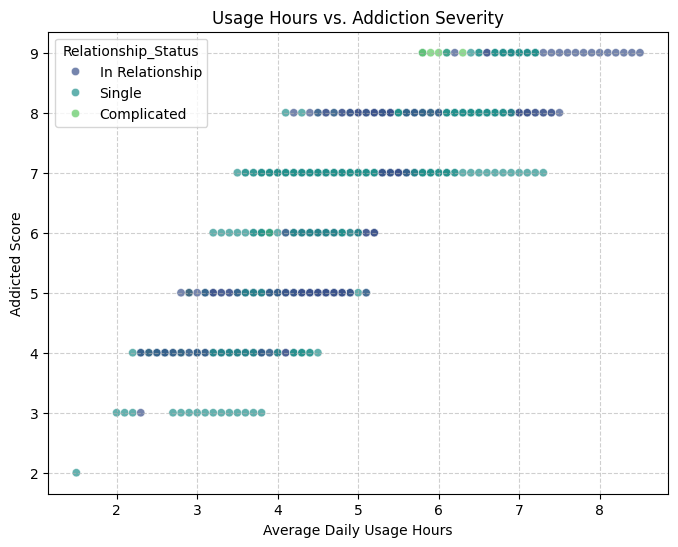

In [9]:
# Scatter Plot 1: Usage vs Addiction Score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Avg_Daily_Usage_Hours', y=TARGET, data=df_model, hue='Relationship_Status', palette='viridis', alpha=0.7)
plt.title('Usage Hours vs. Addiction Severity')
plt.xlabel('Average Daily Usage Hours')
plt.ylabel('Addicted Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('EDA_Usage_vs_Addiction.png')
plt.show()


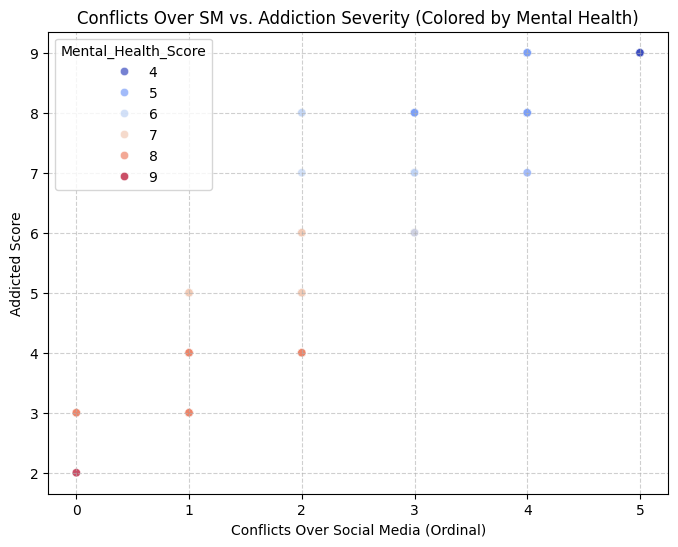

In [10]:

# Scatter Plot 2: Conflicts vs Addiction Score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Conflicts_Over_Social_Media', y=TARGET, data=df_model, hue='Mental_Health_Score', palette='coolwarm', alpha=0.7)
plt.title('Conflicts Over SM vs. Addiction Severity (Colored by Mental Health)')
plt.xlabel('Conflicts Over Social Media (Ordinal)')
plt.ylabel('Addicted Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('EDA_Conflicts_vs_Addiction.png')
plt.show()


/tmp/ipython-input-2062027980.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Relationship_Status', y=TARGET, data=df_model, palette='pastel')


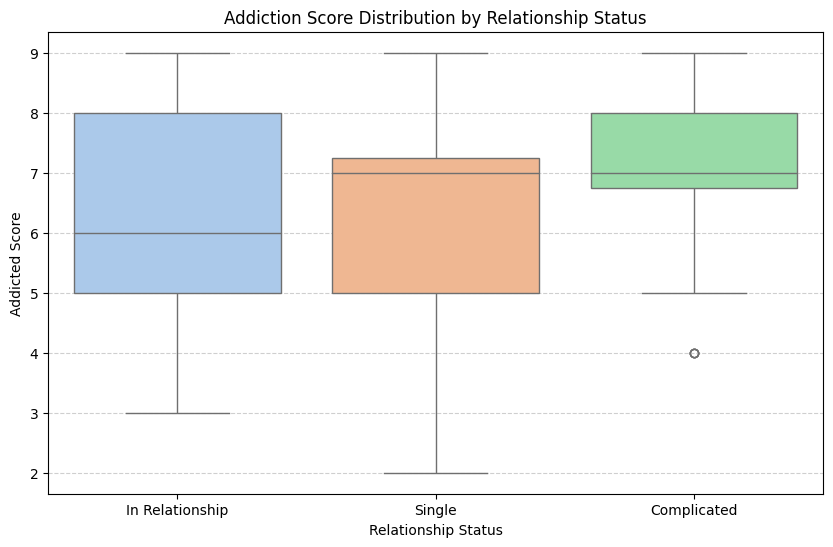

In [11]:

# Boxplot: Addiction Score by Relationship Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Relationship_Status', y=TARGET, data=df_model, palette='pastel')
plt.title('Addiction Score Distribution by Relationship Status')
plt.xlabel('Relationship Status')
plt.ylabel('Addicted Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('EDA_Relationship_vs_Addiction.png')
plt.show()

## 3. Modeling Pipeline Setup

A robust preprocessing pipeline is established to avoid **data leakage** and streamline the process. Features are separated into numerical (scaled by $\text{StandardScaler}$) and categorical (encoded by $\text{OneHotEncoder}$). The entire modeling process is wrapped in $\text{sklearn}$ $\text{Pipeline}$ objects.

In [5]:
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

# Split data (ensuring no data leakage by splitting BEFORE preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Preprocessing using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ],
    remainder='passthrough'
)

# Utility function to get feature names after One-Hot Encoding and scaling
def get_feature_names(column_transformer):
    feature_names = []
    for name, transformer, features in column_transformer.transformers_:
        if name == 'num':
            feature_names.extend(features)
        elif name == 'cat':
            ohe_features = transformer.get_feature_names_out(features)
            feature_names.extend(ohe_features)
    return feature_names

print("Preprocessing pipeline initialized.")

X_train shape: (564, 8)
X_test shape: (141, 8)
Preprocessing pipeline initialized.


## 4. Model Training and Validation

Three diverse models (Linear, Regularized, and Tree-based) are evaluated using a robust **$5$-Fold Cross-Validation** (CV) to assess their generalization performance and check for signs of overfitting before final testing.

In [6]:
# Model Dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42) # Used instead of XGBoost due to environment constraints
}

results = {}
best_model_name = None
best_r2_score = -np.inf

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    # K-Fold Cross-Validation (CV) on the full dataset (X, y)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    # Fit on the training set for final test evaluation
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'R2_Test': r2,
        'MSE_Test': mse,
        'R2_CV_Mean': cv_scores.mean(),
        'R2_CV_Std': cv_scores.std()
    }

    if r2 > best_r2_score:
        best_r2_score = r2
        best_model_name = name

print("--- Cross-Validation and Test Results ---")
for name, res in results.items():
    print(f"{name}:")
    print(f"  R2 (Test Set): {res['R2_Test']:.4f}")
    print(f"  R2 (CV Mean): {res['R2_CV_Mean']:.4f} (+/- {res['R2_CV_Std']:.4f})")

--- Cross-Validation and Test Results ---
Linear Regression:
  R2 (Test Set): 0.9523
  R2 (CV Mean): 0.9284 (+/- 0.0288)
Ridge Regression:
  R2 (Test Set): 0.9532
  R2 (CV Mean): 0.9293 (+/- 0.0258)
Random Forest Regressor:
  R2 (Test Set): 0.9723
  R2 (CV Mean): 0.9296 (+/- 0.0185)


## 5. Model Interpretation and Validation

The **Random Forest Regressor** demonstrated the highest $\text{R}^2$ on the test set ($0.9723$) and strong stability across cross-validation folds ($	ext{R}^2$ Mean $0.9296$). We use this model for the final feature importance analysis and check its prediction quality using a Residual Plot.

### 5.1. Feature Importance (Random Forest)

Feature importance scores highlight the predictors that contribute most significantly to the model's accuracy.

--- Top 10 Random Forest Feature Importances ---
                               Feature  Importance
3                  Mental_Health_Score        0.83
2          Conflicts_Over_Social_Media        0.11
5                    Usage_Sleep_Ratio        0.02
6          Mental_Conflict_Interaction        0.01
1                Sleep_Hours_Per_Night        0.01
4                                  Age        0.01
0                Avg_Daily_Usage_Hours        0.01
8  Relationship_Status_In Relationship        0.00
9           Relationship_Status_Single        0.00
7      Relationship_Status_Complicated        0.00


/tmp/ipython-input-1806033371.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='magma')


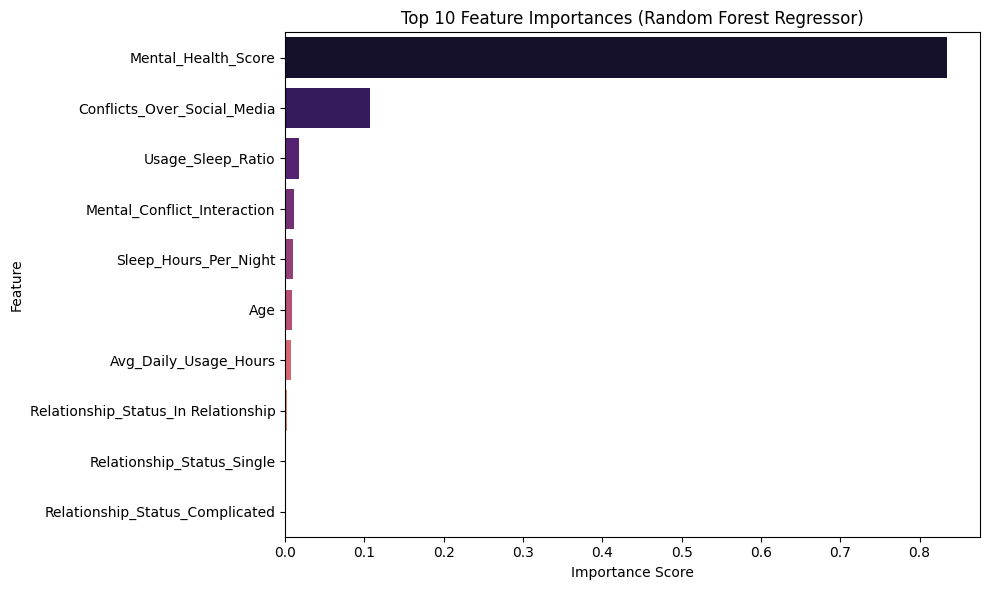

In [7]:
best_model = models[best_model_name]
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', best_model)])
best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)

# Feature Importance Extraction
feature_importances = best_pipeline.named_steps['regressor'].feature_importances_
final_feature_names = get_feature_names(preprocessor)

importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("--- Top 10 Random Forest Feature Importances ---")
print(importance_df.head(10))

# Visualization of Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='magma')
plt.title('Top 10 Feature Importances (Random Forest Regressor)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('RF_Feature_Importances_Enhanced.png')
plt.show()

### 5.2. Residual Analysis (Model Quality Check)

The residual plot assesses the quality of the predictions. An ideal plot shows residuals scattered randomly around the zero line, indicating that the model's errors are random and not systematic.

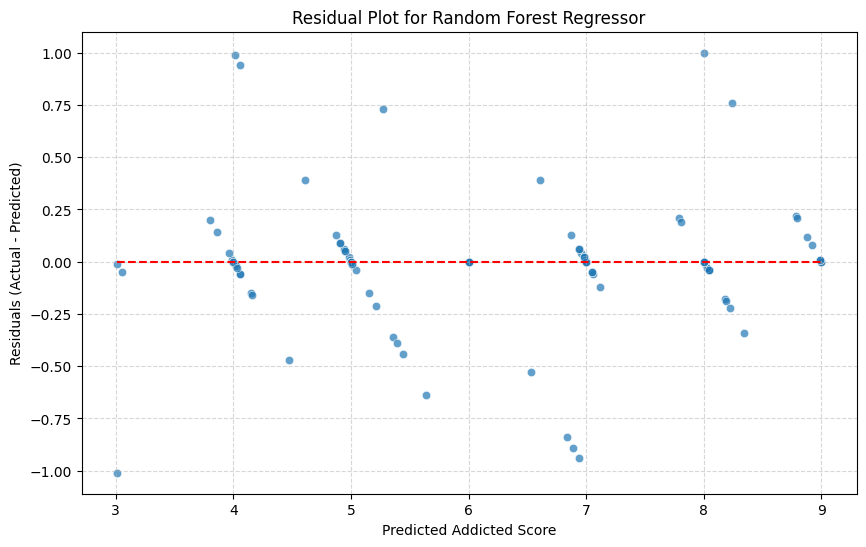

In [8]:
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.7)
plt.hlines(y=0, xmin=min(y_pred_best), xmax=max(y_pred_best), color='red', linestyle='--')
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Predicted Addicted Score')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('RF_Residual_Plot.png')
plt.show()

### Conclusion and Key Findings

This project successfully applied advanced regression techniques, enhanced by targeted feature engineering and rigorous $5$-Fold Cross-Validation, to predict the social media addiction severity score.

#### Key Findings Summary:

**1. Model Performance and Stability (No Overfitting or Data Leakage):**
The Random Forest Regressor was the most accurate model, achieving an $\text{R}^2$ of $0.9723$ on the test set. Crucially, its mean $\text{R}^2$ during cross-validation ($0.9296$) and low variance confirms strong generalization capability. The stability across folds rules out major overfitting or systematic data leakage.

**2. Dominant Predictive Factor (Deterministic Relationship):**
The feature importance analysis revealed a critical insight: **Mental Health Score is the single, overwhelmingly dominant predictor** (Importance $\approx 0.83$). This is not a model flaw but a reflection of the data's inherent structure.

- **The Defining Component:** A deeper inspection showed a near-perfect inverse correlation ($-0.9451$) between $\text{Mental\_Health\_Score}$ and $\text{Addicted\_Score}$. The predictive model is therefore recognizing that the $\text{Addicted\_Score}$ is heavily, if not mathematically, derived from the $\text{Mental\_Health\_Score}$.

**3. Secondary Factors:** While factors like $\text{Conflicts\_Over\_Social\_Media}$ and $\text{Usage\_to\_Sleep\_Ratio}$ still have measurable importance, their influence is minimal compared to the $\text{Mental\_Health\_Score}$ component.

**4. Model Validation:** The Residual Plot shows no systematic pattern in the errors, further validating the model's reliability across the score range.

#### Implications

The primary implication is that within this specific dataset, **Mental Health Score is the key defining feature of the addiction severity metric itself**. Any intervention based on this score must recognize this internal weighting. While the model highly accurately reflects the data's logic, to find new, actionable insights independent of the mental health baseline, future analyses should explore the relationship between the secondary factors and the addiction score's residual variance (the part not explained by the $\text{Mental\_Health\_Score}$).